In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import sys
import glob
import math
import os
import time
from Stitching.functions import *
MAX_MATCHES=30000
sys.setrecursionlimit(20000)


In [2]:
img_dir = r"C:\Users\bedab\OneDrive\AAU\TeeJet-Project\Stitching\m4" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
list_of_lists_of_images = []
#parameters read out from opendronemap
intrinsic=np.array([[3968*0.638904348949862, 0, 2048 ],[0,2976*0.638904348949862,  1536],[0, 0, 1]])
distCoeffs=np.array([0.06756436352714615,-0.09146430991012529,0,0])

for f1 in files:
    img1 = cv2.imread(f1)
    cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    img1=cv2.undistort(img1,intrinsic,distCoeffs)[200:-200,200:-200,:]
    data.append(img1)

w = 3
t = len(data)

for i in range(0, t//w):
    row = data[i*w:(i+1)*w]
    list_of_lists_of_images.append(row)

if t%w != 0:
    i=i+1
    row = data[i*w:-1]
    list_of_lists_of_images.append(row)
    

  

In [3]:
homographys=[find_homography(list_of_lists_of_images[0][1],list_of_lists_of_images[1][1]),find_homography(list_of_lists_of_images[2][1],list_of_lists_of_images[1][1])]
print(homographys)
connections=[((0,1),(1,1)),((2,1),(1,1))]
og_coordinate=(1,1)

    
#res=multiple(list_of_lists_of_images,homographys,connections,og_coordinate)

10000
10001
374
10000
10001
71
[array([[ 8.70201432e-01, -4.43369863e-01,  6.08347937e+02],
       [ 4.14496345e-01,  9.16226089e-01,  3.59388544e+02],
       [-1.55174201e-05, -2.90784830e-06,  1.00000000e+00]]), array([[ 9.71783204e-01, -3.09184583e-03,  1.09829007e+02],
       [ 3.67703679e-03,  9.49182221e-01, -8.29240481e+02],
       [-2.44048205e-06,  2.05645298e-06,  1.00000000e+00]])]


4525
-1064
4031
-1714
5745
5589
start calculating closest image map
0.018709421157836914
generating the closest image map took 0 seconds
(5589, 5745)
5589
5745


ValueError: could not broadcast input array from shape (2576,3568,3) into shape (2576,2873,3)

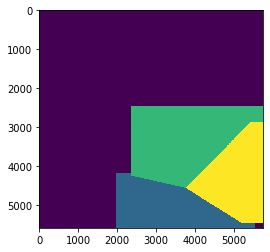

In [4]:
#x_center_original_img=(og_coordinate[0]+0.5)*list_of_lists_of_images[0][0].shape[1]
#y_center_original_img=(og_coordinate[0]+0.5)*list_of_lists_of_images[0][0].shape[0]
#offset_y=og_coordinate[0]*list_of_lists_of_images[0][0].shape[0]
#offset_x=og_coordinate[0]*list_of_lists_of_images[0][0].shape[1]

#offset=np.array([[1, 0, offset_x],[0,1,offset_y],[0,0,1]])

#img_centers=[]
#for homography in homographys:
    #center=apply_homography_to_point((offset_x*0.5,offset_y*0.5),np.matmul(offset,homography))
    #img_centers.append(center)
#img_centers.append((x_center_original_img,y_center_original_img))


    
    
#w=list_of_lists_of_images[0][0].shape[1]
#h=list_of_lists_of_images[0][0].shape[0]
#closest_map=closest_image_map((len(list_of_lists_of_images)*h), len(list_of_lists_of_images[0])*w, img_centers, h, w,downscaling_factor=4)
#for coordinate in img_centers:
#    closest_map[int(coordinate[0])-100:int(coordinate[0])+100,int(coordinate[1])-100:int(coordinate[1])+100]=0
#plt.imshow(closest_map)


res=multiple_v2(list_of_lists_of_images,connections,homographys, (1,1))

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')  
cv2.imwrite('res.jpg',res)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))